In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [3]:
na=['?']
column_names=['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
               'length', 'width', 'height', 'curb-weight', 'engine-type', ' num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower',
               'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
df = pd.read_csv('imports-85.data', header=None , na_values=na , names=column_names)

In [4]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


**DATA PREPROCESSING**

(i) Replace Nan values

In [8]:
# Find which columns have Nan values
df.isna().sum()


symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
 num-of-cylinders     0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Filling NaN  values in our dataframe with modes and mean values for categorical and numerical data respectively.

In [9]:
for col in df.columns:
  if (df.dtypes[col] != np.float64 and df.dtypes[col] != np.int64):
    df[col].fillna(df[col].mode().loc[0],inplace=True)
  else:
    df[col].fillna(df[col].mean(),inplace=True)
df.isna().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
 num-of-cylinders    0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

(ii) Min Max Scaling: As the values in some columns have different scales, we do Min-Max Scaling to bring it to range [0,1].

In [16]:
for col in df.columns:
  if ( (df.dtypes[col] == np.float64 or df.dtypes[col] == np.int64 ) and col!='price'):
    a = df[col].min()
    b = df[col].max()
    df[col] = df[col].apply(lambda x: (x-a)/(b-a))
# df.head()

In [17]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,1.0,0.298429,alfa-romero,gas,std,two,convertible,rwd,front,0.058309,0.413433,0.316667,0.083333,0.411171,dohc,four,0.260377,mpfi,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,13495.0
1,1.0,0.298429,alfa-romero,gas,std,two,convertible,rwd,front,0.058309,0.413433,0.316667,0.083333,0.411171,dohc,four,0.260377,mpfi,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,16500.0
2,0.6,0.298429,alfa-romero,gas,std,two,hatchback,rwd,front,0.230321,0.449254,0.433333,0.383333,0.517843,ohcv,six,0.343396,mpfi,0.100000,0.666667,0.1250,0.441667,0.346939,0.166667,0.263158,16500.0
3,0.8,0.518325,audi,gas,std,four,sedan,fwd,front,0.384840,0.529851,0.491667,0.541667,0.329325,ohc,four,0.181132,mpfi,0.464286,0.633333,0.1875,0.225000,0.551020,0.305556,0.368421,13950.0
4,0.8,0.518325,audi,gas,std,four,sedan,4wd,front,0.373178,0.529851,0.508333,0.541667,0.518231,ohc,five,0.283019,mpfi,0.464286,0.633333,0.0625,0.279167,0.551020,0.138889,0.157895,17450.0


(iii) Creating one-hot vector for categorical features

In [19]:
categorical_cols = [col for col in df.columns if (df.dtypes[col] != np.float64 and df.dtypes[col] != np.int64)]
df = pd.get_dummies(df, columns = categorical_cols)


Now the columns become :
   symboling  normalized-losses  ...  fuel-system_spdi  fuel-system_spfi
0        1.0           0.298429  ...                 0                 0
1        1.0           0.298429  ...                 0                 0
2        0.6           0.298429  ...                 0                 0
3        0.8           0.518325  ...                 0                 0
4        0.8           0.518325  ...                 0                 0

[5 rows x 76 columns]


In [20]:
print("Now the columns become :")
df.head()

Now the columns become :


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,fuel-type_diesel,fuel-type_gas,aspiration_std,aspiration_turbo,num-of-doors_four,num-of-doors_two,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon,drive-wheels_4wd,drive-wheels_fwd,drive-wheels_rwd,engine-location_front,engine-location_rear,engine-type_dohc,engine-type_dohcv,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,13495.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.441667,0.346939,0.166667,0.263158,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.225000,0.551020,0.305556,0.368421,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.279167,0.551020,0.138889,0.157895,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


(iv) Bring the label column -ie- price to the last.

In [22]:
tmp = df['price']
df.drop('price', axis=1, inplace=True)
df['price'] = tmp
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,fuel-type_diesel,fuel-type_gas,aspiration_std,aspiration_turbo,num-of-doors_four,num-of-doors_two,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon,drive-wheels_4wd,drive-wheels_fwd,drive-wheels_rwd,engine-location_front,engine-location_rear,engine-type_dohc,engine-type_dohcv,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,engine-type_rotor,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi,price
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,13495.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,16500.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.441667,0.346939,0.166667,0.263158,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,16500.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.225000,0.551020,0.305556,0.368421,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,13950.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.279167,0.551020,0.138889,0.157895,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,17450.0


##**NEAREST NEIGHBOR ALGORITHM**

##Cross Validation for estimating optimum 'k' value in kNN

In [30]:
def calculatePrice(x, index , k):
  temp = []
  for i in range(len(training_data)):
    d = {}
    d['price'] = training_data.iloc[i, 75]
    d['distance'] = np.linalg.norm(np.array(x.iloc[index, 0:75])-np.array(training_data.iloc[i,0:75]), ord=2)
    temp.append(d)
  
  #Sorting the temp array which contains the prices and corresponding distance of that point from sample point.
  temp = sorted(temp, key=lambda x:x['distance'])
  
  #Selecting the 'k' nearest neighbors
  k_nearest_neighbors = temp[:k]

  predicted_price = sum(d['price'] for d in k_nearest_neighbors)
  predicted_price = predicted_price/k
  return predicted_price

In [31]:
def kNN(test_data, k):
  squared_error_sum = 0

  #Iterate over all test_data points and find their predicted prices to calculate the sum of the mean squared errors
  for i in range(len(test_data)):
    predicted_price = calculatePrice(test_data, i ,k)
    actual_price = test_data.iloc[i,75]
    squared_error_sum += (predicted_price-actual_price)**2

  mean_squared_error = squared_error_sum / len(test_data)
  return np.sqrt(mean_squared_error) 

## Ans 1(a): Average RMS Error using k-fold cross validation

In [32]:
import random
errors = []
for k in range(1,15):
  
  rms_error = 0

  for state in random.sample(range(20,40), 10):
    
    training_data = df.sample(frac=0.75, random_state = state) #Taking 75% data as training data and leaving rest as testing data
    testing_data = df.drop(training_data.index)
    validation_data = training_data.sample(frac=0.25, random_state = state)
    training_data = training_data.drop(validation_data.index)

    # Calculating the root mean squared error for current value of 'k'
    rms_error = rms_error + kNN(validation_data,k)
  
  avg_rms_error = rms_error/10

  temp = {}
  temp["avg_rms_error"] = avg_rms_error
  temp["k"] = k
  print(k,avg_rms_error)
  errors.append(temp)  

#Ans 1(b) Validation Set Performance for optimal k value

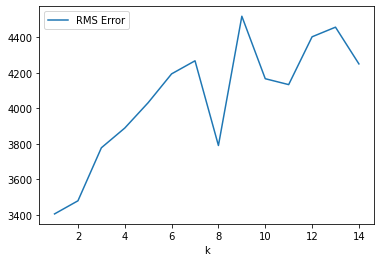

In [37]:
rmse_df = pd.DataFrame(errors) 
rmse_df.plot( y= 'avg_rms_error', x= 'k',label="RMS Error")
print("Optimal k = ",2)

##Ans 1(c): L0 Regularization

In [43]:
def genSubLists (l):
    permutations = [()]
    for i in range(len(l) + 1):
        for j in range(i):
            permutations.append(set(l[j: i]))
    return permutations
    
column_idx = [i for i in range(0,75)]
permutations = genSubLists(column_idx)[1:]

for items in permutations:
    items.add(75)
    

def calculatePrice1(x,ind,k, cols):
    
    out = []
    for i in range(len(training_data)):
        d = {}
        d['price'] = training_data.iloc[i, len(cols)-1]
        d['distance'] = np.linalg.norm(np.array(x.iloc[ind, :])-np.array(df.iloc[i, cols]), ord=2)
        
        
        out.append(d)
    
    out = sorted(out, key=lambda x:x['distance'])[:k]   
    
    mean = sum(d['price'] for d in out)/k
    return mean


def kNN1(testing, k, cols):
  mse_sum = 0
  #print(cols)
  for i in range(len(testing)):
    predicted_price = calculatePrice1(testing, i ,k,cols)
    actual_price = testing.iloc[i,len(cols)-1]
    mse_sum += (predicted_price-actual_price)**2
          
  return np.sqrt(mse_sum/len(testing))   

k = 2 #learnt from CV
final_cols = []

for i in range(len(permutations)):
    
    df1 = df.iloc[:,list(permutations[i])]
   
      
    training_data = df1.sample(frac=0.75)
    testing_data = df1.drop(training_data.index)
    
    validation_data = training_data.sample(frac=0.25)
    training_data = training_data.drop(validation_data.index)
    
   

    
    alpha = {}
    alpha['columns'] = permutations[i]
    alpha['rmse'] = kNN1(validation_data, k, list(permutations[i]))
    final_cols.append(alpha)
    print(i+1)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [44]:
answer = pd.DataFrame(data=final_cols)
answer.to_csv('21111063.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Ans 1(d): 
As observed, by doing L0 regularisation, there is a aprrox gain of 50% accuracy. This has been possible because by using L0 normalization, it gives us a list of most probable features which is shown in zip file. The features column numbers are 
{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 75}
These features do make sense because it consists of engine horsepower, company, fuel type, stroke etc. For example as in a car, the brand value of the car is always an important predictor of the sale value clubbed with its technical specifications.

As evident from the 1836th entry in the 21111063.csv file, there is a significant reduction in our RMS Error value when K=2.
Hence, it is successfully inferred that L0 regularization improves the RMS Error value.

#**ANSWER 2**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Saving adult.data to adult.data


In [4]:
na = ['?']
column_names = ['age','workclass','number','education','edu_num','marital status','occupation','relationship','race','sex','gain','loss','hpw','country','income']
df = pd.read_csv('adult.data', header=None , na_values=na , names=column_names)

In [5]:
df.head()

,age,workclass,number,education,edu_num,marital status,occupation,relationship,race,sex,gain,loss,hpw,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


##**DATA PREPROCESSING**

In [7]:
#cleaning
df = df.replace(' ?',np.nan)
df.isna().sum()

df.fillna(df.mode().loc[0], inplace=True)
df.isna().sum()




for col in column_names:
  df[col], tmp  = pd.Series(list(df[col])).factorize()

#df.drop(['gain', 'loss'], axis = 1)

df.info()


for col in column_names:
    maxx = df[col].max()
    minn = df[col].min()
    
    
    df[col] = df[col].apply(lambda x: (x-minn)/(maxx-minn))
    
for d in ['number', 'gain', 'loss', 'edu_num', 'income', 'age']:
    column_names.remove(d)

#df.drop(['fnlwgt', 'capital-gain', 'capital-loss', 'education-num'], axis=1, inplace=True)

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int64
 2   number          32561 non-null  int64
 3   education       32561 non-null  int64
 4   edu_num         32561 non-null  int64
 5   marital status  32561 non-null  int64
 6   occupation      32561 non-null  int64
 7   relationship    32561 non-null  int64
 8   race            32561 non-null  int64
 9   sex             32561 non-null  int64
 10  gain            32561 non-null  int64
 11  loss            32561 non-null  int64
 12  hpw             32561 non-null  int64
 13  country         32561 non-null  int64
 14  income          32561 non-null  int64
dtypes: int64(15)
memory usage: 3.7 MB


,age,workclass,number,education,edu_num,marital status,occupation,relationship,race,sex,gain,loss,hpw,country,income
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.000,0.0
1,0.013889,0.142857,0.000046,0.000000,0.000000,0.166667,0.076923,0.2,0.00,0.0,0.008475,0.0,0.010753,0.000,0.0
2,0.027778,0.285714,0.000092,0.066667,0.066667,0.333333,0.153846,0.0,0.00,0.0,0.008475,0.0,0.000000,0.000,0.0
3,0.041667,0.285714,0.000139,0.133333,0.133333,0.166667,0.153846,0.2,0.25,0.0,0.008475,0.0,0.000000,0.000,0.0
4,0.055556,0.285714,0.000185,0.000000,0.000000,0.166667,0.230769,0.4,0.25,1.0,0.008475,0.0,0.000000,0.025,0.0


In [8]:

def ent(col):
    counts = np.unique(col,return_counts=True)
    ent = 0.0
    for ix in counts[1]:
        p = ix/col.shape[0]
        ent += (-1.0*p*np.log2(p))
    return ent

def splitd(x_data,fkey,fval):
    x_right = pd.DataFrame([],columns=x_data.columns)
    x_left = pd.DataFrame([],columns=x_data.columns)
    for i in range(x_data.shape[0]):
        val = x_data[fkey].loc[i]
        if val >=fval:
            x_right = x_right.append(x_data.iloc[i])
        else:
            x_left = x_left.append(x_data.iloc[i])
    return x_right,x_left

def ig(x_data,fkey,fval):
    right,left = splitd(x_data,fkey,fval)
    
    l = float(left.shape[0])/x_data.shape[0]
    r = float(right.shape[0])/x_data.shape[0]
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -99999
    i_gain = ent(x_data.income) - (l * ent(left.income) + r*ent(right.income))
    return i_gain



In [9]:
class DecisionTree:
    def __init__(self,depth=0,max_depth=10):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.depth = depth
        self.max_depth = max_depth
        self.target = None
    def train(self,x_train):
        features=column_names
        info_gains = []
        for ix in features:
            i_gain = ig(x_train,ix,x_train[ix].mean())
            info_gains.append(i_gain)
        self.fkey = features[np.argmax(info_gains)]
        self.fval = x_train[self.fkey].mean()
        print("Splitting Tree",self.fkey)
        data_right,data_left = splitd(x_train,self.fkey,self.fval)
        data_right = data_right.reset_index(drop=True)
        data_left = data_left.reset_index(drop=True)
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            if x_train.income.mean() >= 0.5:
                self.target = "Positive"
            else:
                self.target = "Negative"
            return
        if self.depth >= self.max_depth:
            if x_train.income.mean() >= 0.5:
                self.target = "Positive"
            else:
                self.target = "Negative"
            return
        self.left = DecisionTree(self.depth+1,self.max_depth)
        self.left.train(data_left)
        self.right = DecisionTree(self.depth+1,self.max_depth)
        self.right.train(data_right)
        if x_train.income.mean() >= 0.5:
            self.target = "Positive"
        else:
            self.target = "Negative"
        return
    def predict(self,test):
        if test[self.fkey] > self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        if test[self.fkey] <= self.fval:
            if self.left is None:
                return self.target
            return self.left.predict(test)



In [15]:
split = int(0.7*df.shape[0])
train_data = df[:split]
test_data = df[split:]
test_data= test_data.reset_index(drop=True)

dt = DecisionTree()

train_data


dt.train(train_data[:50])

y_pred = []
for ix in range(test_data.shape[0]):
    y_pred.append(dt.predict(test_data.loc[ix]))

y_pred[:10]

for i in range(len(y_pred)):
    if y_pred[i] == "Negative":
        y_pred[i] = 0
    else:
        y_pred[i] = 1



Splitting Tree relationship
Splitting Tree relationship
Splitting Tree sex
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree marital status
Splitting Tree workclass
Splitting Tree occupation
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree occupation
Splitting Tree workclass
Splitting Tree country
Splitting Tree occupation
Splitting Tree education
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree education
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree workclass
Splitting Tree education
Splitting Tree occu

#Ans 2(a) : Validation Set Performance

In [16]:
print("The prediction accuracy is {}%".format(np.mean(y_pred == test_data['income'])*100))

The prediction accuracy is 69.4339236359914%


#Ans 2(b): Cross Validation to optimize the tree parameters.

In [ ]:
possible_tree_depths = [7,8,9,10]

for md in possible_tree_depths:
    dt = DecisionTree(max_depth = md)
    dt.train(train_data)
    y_pred = []
    for ix in range(valid_data.shape[0]):
        y_pred.append(dt.predict(valid_data.loc[ix]))

    y_pred[:10]

    for i in range(len(y_pred)):
        if y_pred[i] == "Negative":
            y_pred[i] = 0
        else:
            y_pred[i] = 1

    print("At Depth:",str(md), ";", "Accuracy is", str(round(np.mean(y_pred == valid_data['income'])*100,2)), '%')
    
    
    

As shown above, at different values of depths, the accuracy is shown.